# Bonus Lecture.  

## Classical Seasonal Decomposition

In this notebook you will learn how to:

* Manually use additive and seasonal decomposition i.e. **without** using `statsmodels`
* Seasonally adjust your time series to remove seasonal fluctuations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The ED arrivals dataset.

The dataset we will use represent monthly adult (age > 18) arrivals to an Emergency Department.  The observations are between April 2009 and May 2017. 

In [2]:
url = "https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/ed_mth_ts.csv"
ed_month = pd.read_csv(url, index_col='date', parse_dates=True)
ed_month.index.freq = 'MS'

arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month

The first thing you should do when exploring a time series is check its length and duration.

In [3]:
#This tells us how many months are in the ts
arrival_rate.shape 

(98,)

### Breaking a times series up into its trend and seasonal components.

To help visualise and understand trend and seasonality in a time series we can use seasonal decomposition.

This is a model based approach that breaks the time series into three components.  The basic approach to seasonal decomposition has two forms: additive and multiplicative.  

#### Additive decomposition

If we assume that an observation at time t $Y_t$ is the additive sum of trend $T_t$, seasonality $S_t$ and random error $E_t$.  then we have the following model.

$Y_t = T_t + S_t + E_t$

We then to make this assumption when the seasonal fluctuations are constant across the time series.  This looks like a reasonable assumption in the case of the ED data.

#### Multiplicative decomposition

If the seasonal fluctuations of the data grow over time then it is best to a multiplicative model. Where an observation at time t $Y_t$ is the product of multiply the trend $T_t$, seasonality $S_t$ and random error $E_t$

$Y_t = T_t \cdot  S_t \cdot  E_t$

## Manually performing a seasonal decomposition

Classical decomposition is straightfoward to implement.  We will work with additive seasonality first.

### **Additive Seasonality**

**Step 1: Estimate the trend component**

The first thing to do is estimate the trend in the time series.  We do this using a 12 month centered moving average.

In [4]:
decomp = pd.DataFrame(arrival_rate)
decomp.columns = ['actual']

In [5]:
decomp['trend'] = arrival_rate.rolling(window=12, center=True).mean()

<Axes: xlabel='date'>

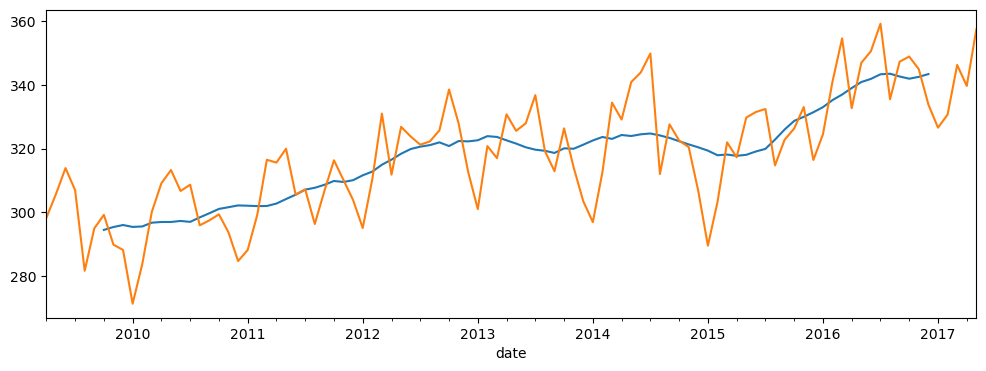

In [6]:
ax = decomp.trend.plot(figsize=(12,4))
arrival_rate.plot(ax=ax)

**Step 2: Detrend the series**

We first need to **de-trend** the time series.  In the additive model we do this by **subtracting** the trend from the actual observations of the time series.

$Y_t - T_t = S_t + E_t$

In [7]:
detrended = decomp['actual'] - decomp['trend']

When we plot this notice that the upward trend of the data has been removed.

<Axes: xlabel='date'>

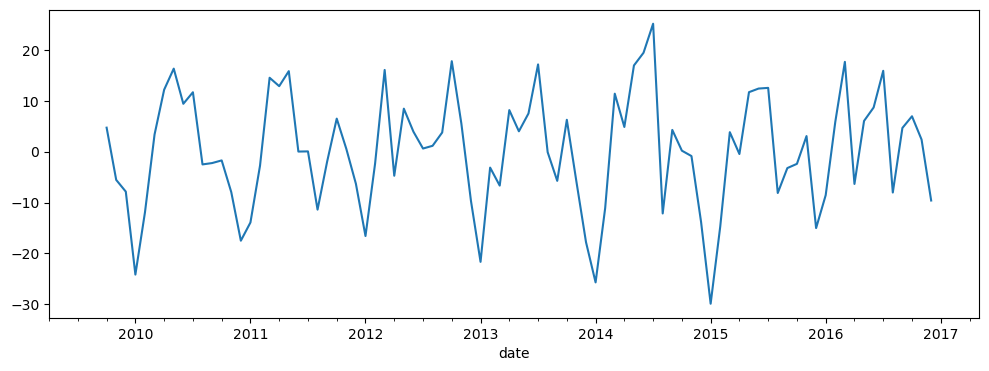

In [8]:
detrended.plot(figsize=(12,4))

**Step 3: Calculate the seasonal indicies**

Classic decomposition assumes that seasonality is constant year to year.  This means we only need to calculate one value for each month of the year.

We work with the detrended series. To calculate the seasonal indicies we group by month and take the average of the detrended series.  This is easy in pandas with a group by operation.

In [9]:
seasonal_indexes = detrended.groupby(by=detrended.index.month).mean()

<Axes: xlabel='date'>

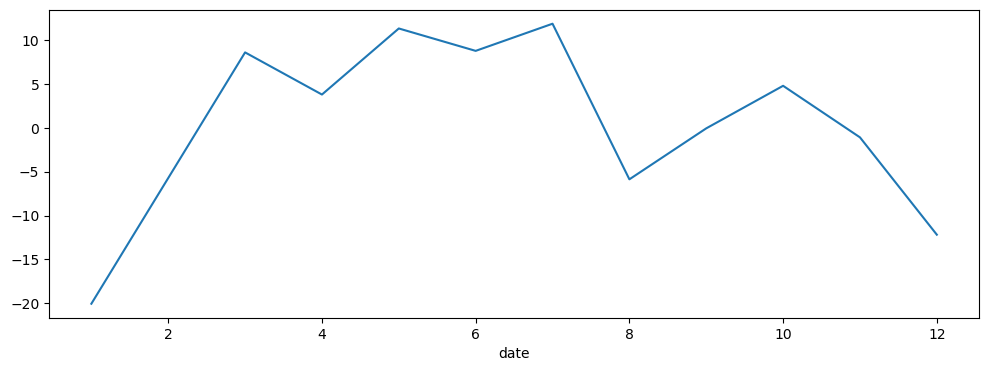

In [10]:
seasonal_indexes.plot(figsize=(12,4))

We then want to **map** the seasonal indicies to the rows in the time series.  

In [11]:
decomp['seasonal'] = decomp.index.month.map(seasonal_indexes)

In [12]:
decomp.head(10)

,actual,trend,seasonal
date,,,
2009-04-01,298.266667,NaN,3.799460
2009-05-01,305.709677,NaN,11.333178
2009-06-01,313.900000,NaN,8.779132
2009-07-01,306.967742,NaN,11.874601
2009-08-01,281.612903,NaN,-5.867335
2009-09-01,294.933333,NaN,-0.055819
2009-10-01,299.193548,294.467371,4.795828
2009-11-01,289.833333,295.372926,-1.082890
2009-12-01,288.161290,296.004647,-12.179799


**Step 4: Calculate the remainder**

The irregular component $E_t$ is calculated by subtracting the trend and seasonal components from the actual.

$E_t = Y_t - T_t - S_t$

In [13]:
decomp['resid'] = decomp['actual'] - decomp['trend'] - decomp['seasonal']

## Seasonal Decomposition Plot

Text(0, 0.5, 'remainder')

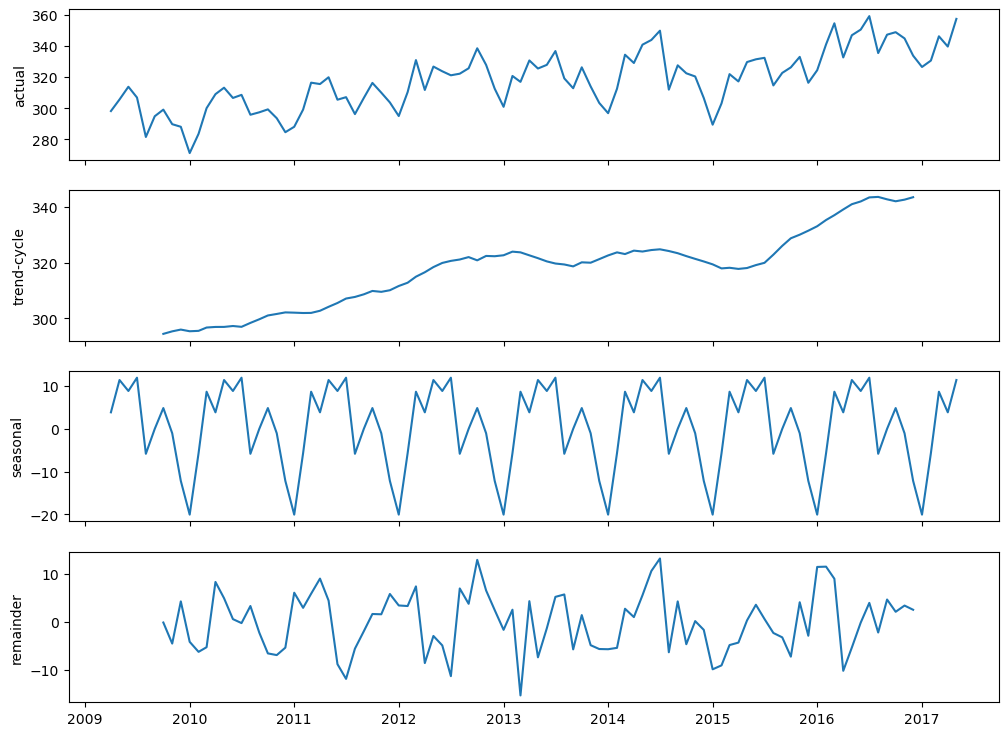

In [14]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12,9))
axes[0].plot(decomp['actual'])
axes[1].plot(decomp['trend'])
axes[2].plot(decomp['seasonal'])
axes[3].plot(decomp['resid'])

axes[0].set_ylabel('actual')
axes[1].set_ylabel('trend-cycle')
axes[2].set_ylabel('seasonal')
axes[3].set_ylabel('remainder')

## Seasonal Adjustment: A side product of decomposition

$Y_t - S_t = T_t + E_t$

Many economic time series are publishing using a seasonally adjusted data.  This is achieved by subtrack the seasonal indicies from the observerd time series.

In [15]:
seasonal_adj = decomp['actual'] - decomp['seasonal']

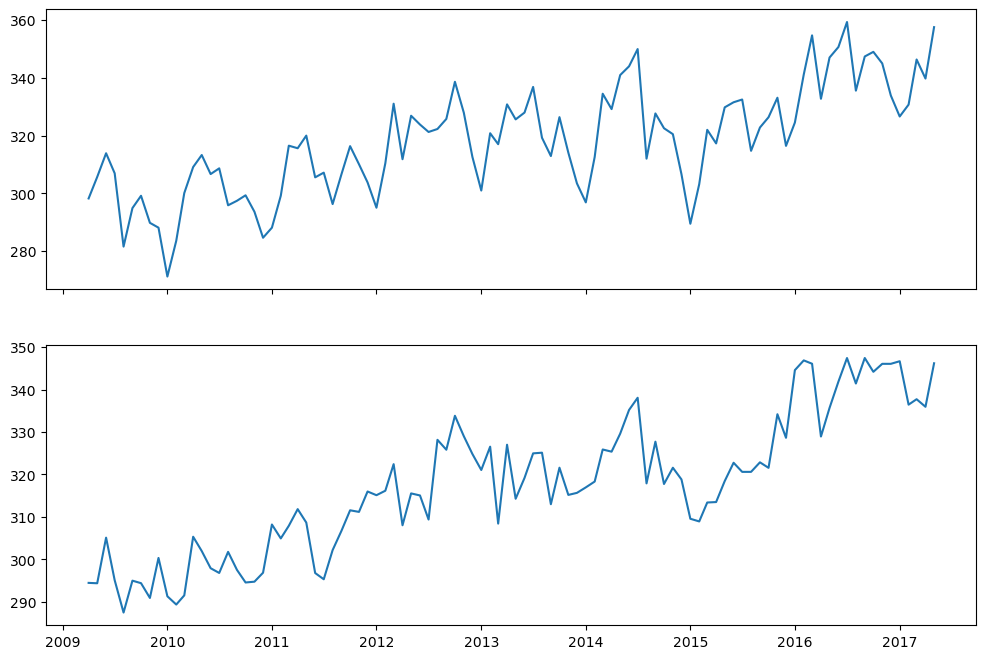

In [16]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))
axes[0].plot(arrival_rate)
axes[1].plot(seasonal_adj)

## Multiplicative Seasonality

In [17]:
url = "https://raw.githubusercontent.com/health-data-science-OR/hpdm097-datasets/master/Alcohol_Sales.csv"
sales = pd.read_csv(url, index_col='DATE', parse_dates=True)
sales.index.freq = 'MS'
sales_rate = sales['sales'] / sales.index.days_in_month

<Axes: xlabel='DATE'>

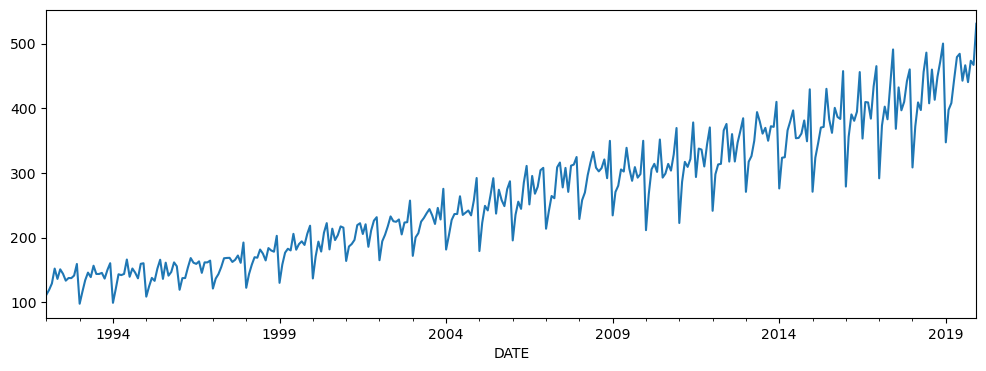

In [18]:
sales_rate.plot(figsize=(12,4))

**Step 1: Estimate the trend component**

As before we will do this using a 12 month 'centered' moving average.

In [19]:
decomp = pd.DataFrame(sales_rate)
decomp.columns = ['actual']

In [20]:
decomp['trend'] = sales_rate.rolling(window=12, center=True).mean()

<Axes: xlabel='DATE'>

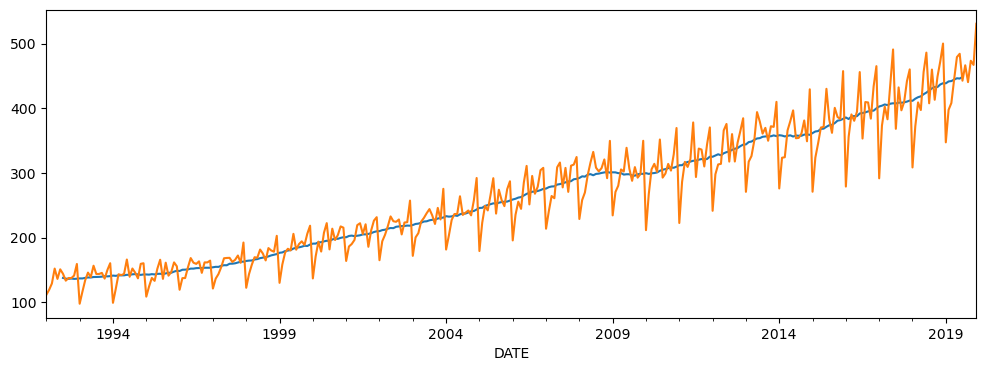

In [21]:
ax = decomp.trend.plot(figsize=(12,4))
sales_rate.plot(ax=ax)

**Step 2: Detrend the series**

We first need to **de-trend** the time series.  In the additive model we do this by **dividing** the trend from the actual observations of the time series.

$Y_t = T_t \cdot  S_t \cdot  E_t$

In [22]:
detrended = decomp['actual'] / decomp['trend']

<Axes: xlabel='DATE'>

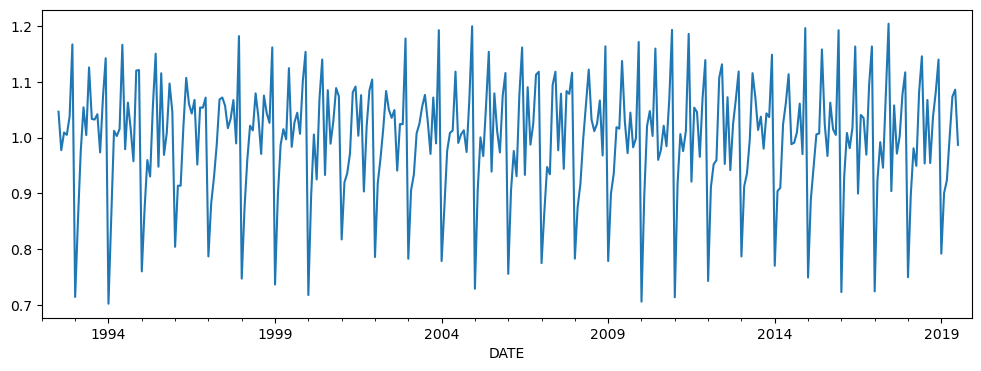

In [23]:
detrended.plot(figsize=(12,4))

**Step 3: Calculate the seasonal indicies**

We again work with the detrended series. To calculate the seasonal indicies we group by month and take the average of the detrended series. Note that the indicies are now proportion above and below the mean level of the series.

In [24]:
seasonal_indexes = detrended.groupby(by=detrended.index.month).mean()

<Axes: xlabel='DATE'>

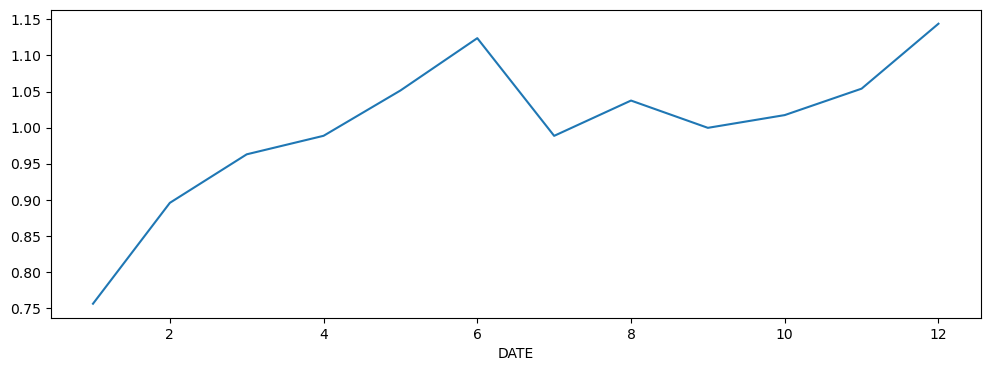

In [25]:
seasonal_indexes.plot(figsize=(12,4))

We then want to **map** the seasonal indicies to the rows in the time series. 

In [26]:
decomp['seasonal'] = decomp.index.month.map(seasonal_indexes)

In [27]:
decomp.head(10)

,actual,trend,seasonal
DATE,,,
1992-01-01,111.580645,NaN,0.755997
1992-02-01,119.241379,NaN,0.895749
1992-03-01,129.096774,NaN,0.962968
1992-04-01,152.133333,NaN,0.988634
1992-05-01,136.161290,NaN,1.051403
1992-06-01,150.966667,NaN,1.123895
1992-07-01,144.064516,137.681316,0.988569
1992-08-01,133.451613,136.530778,1.037465
1992-09-01,137.533333,136.299354,0.999662


**Step 4: Calculate the remainder**

The irregular component $E_t$ is calculated by dividing by the trend and seasonal components from the actual.

$E_t = \frac{Y_t}{T_t S_t}$

In [28]:
decomp['resid'] = decomp['actual'] / (decomp['trend'] * decomp['seasonal'])

In [29]:
decomp.head()

,actual,trend,seasonal,resid
DATE,,,,
1992-01-01,111.580645,NaN,0.755997,NaN
1992-02-01,119.241379,NaN,0.895749,NaN
1992-03-01,129.096774,NaN,0.962968,NaN
1992-04-01,152.133333,NaN,0.988634,NaN
1992-05-01,136.161290,NaN,1.051403,NaN


### Seasonal decomp plot

Text(0, 0.5, 'remainder')

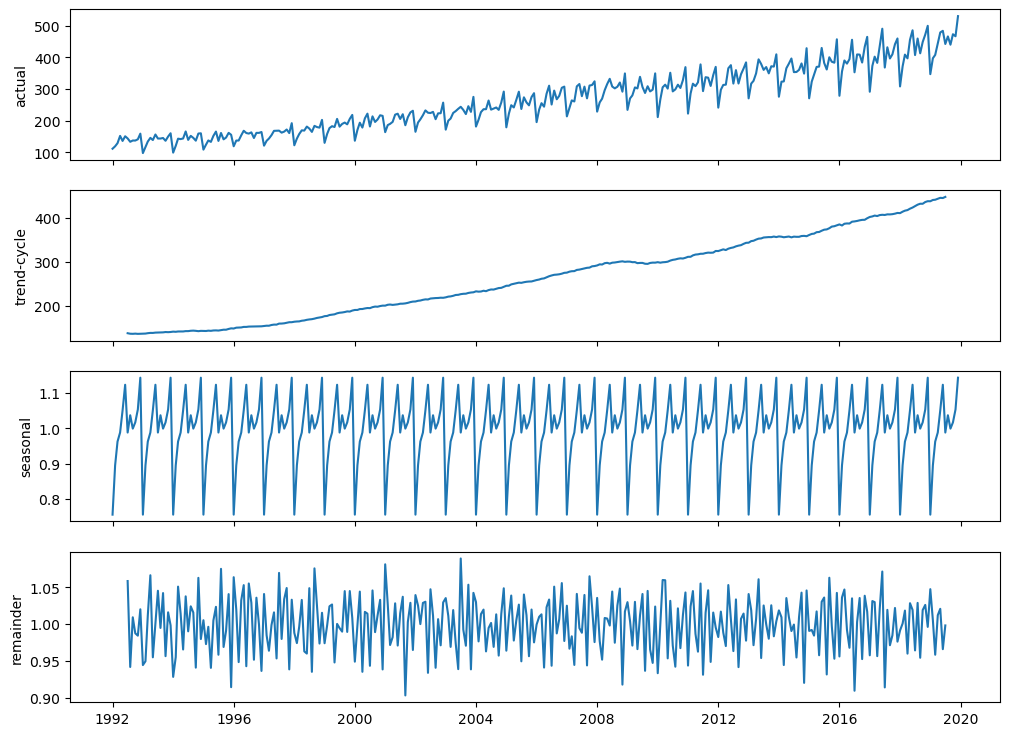

In [30]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12,9))
axes[0].plot(decomp['actual'])
axes[1].plot(decomp['trend'])
axes[2].plot(decomp['seasonal'])
axes[3].plot(decomp['resid'])

axes[0].set_ylabel('actual')
axes[1].set_ylabel('trend-cycle')
axes[2].set_ylabel('seasonal')
axes[3].set_ylabel('remainder')

## Seasonal Adjustment.

$\frac{Y_t}{S_t} = T_t \cdot E_t$

Many economic time series are publishing using a seasonally adjusted data.  This is achieved by dividing the observed time series by the seasonal indicies.

<Axes: xlabel='DATE'>

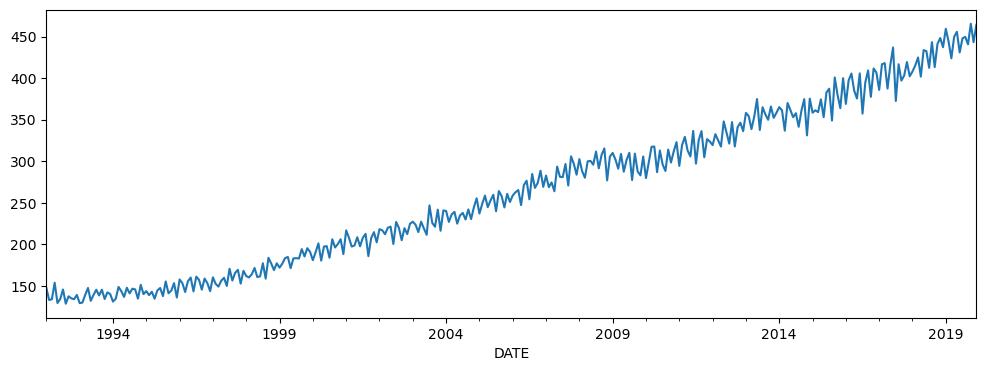

In [31]:
seasonal_adj = decomp['actual'] / decomp['seasonal']
seasonal_adj.plot(figsize=(12,4))